<a href="https://colab.research.google.com/github/Annie00000/Project/blob/main/%E7%9C%BC%E7%9D%9B%E7%96%BE%E7%97%85%E5%88%A4%E5%88%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 檢查GPU

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# check the allocated GPU type
!nvidia-smi

Thu Dec 21 14:37:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 套件

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import shutil

# from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers,models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Dense, Flatten  # 放入Dense層前先flatten
from tensorflow.keras.optimizers import SGD ,Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
seed_value = 223
tf.random.set_seed(seed_value)

## 上傳資料

### kaggle 上傳

* Step 1 : 登入 Kaggle > My Account > Create New API Token，這步會在你的電腦下載一個 kaggle.json 檔案。

* Step2 : 開啟 Google Colab 輸入以下指令，並"選擇"剛剛下載好的 kaggle.json 檔案。


In [ ]:
!pip install -U -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annie014","key":"aa55f2cc9c5cb070c8ec1013f07ce08d"}'}

* Step 3 : 上傳成功後，將檔案移至伺服器端的 ~/.kaggle 底下，並且更改權限，只限本人帳號可以讀取：

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

* Step4 : Copy API command 並貼上 (download 資料)

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

 99% 725M/736M [00:06<00:00, 107MB/s]
100% 736M/736M [00:06<00:00, 111MB/s]


* Step5 : 建議先執行以下語法建立一個資料夾，之後再將壓縮檔解壓縮進去，環境比較不容易亂
* Step6 : 執行以下語法解壓縮，這時候就可以看到解壓縮後裡面的檔案名稱

In [ ]:
# 建立一個名為 eye-diseases-classification 的資料夾
! mkdir eye-diseases-classification

In [ ]:
# 將剛剛載下來的.zip壓縮檔解壓縮進 eye_diseases 資料夾裡
! unzip eye-diseases-classification.zip -d eye-diseases-classification

Archive:  eye-diseases-classification.zip
  inflating: eye-diseases-classification/dataset/cataract/0_left.jpg  
  inflating: eye-diseases-classification/dataset/cataract/103_left.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1062_right.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1083_left.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1084_right.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1102_left.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1102_right.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1115_left.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1126_right.jpg  
  inflating: eye-diseases-classification/dataset/cataract/112_right.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1144_left.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1144_right.jpg  
  inflating: eye-diseases-classification/dataset/cataract/1164_left.j

### 電腦裡上傳

## Data preprocessing

### 加載數據

> 狀態一 : 只有一個data (此資料集is這個狀態)

* 一次導入所有data，再去切分資料 (可以考慮要不要做k-fold)



In [ ]:
data_dir = pathlib.Path("eye-diseases-classification/dataset")
# image_dataset_from_directory : 加載資料 (參數 batch_size: 数据批次的大小。默认值：32)
seed=223
data = image_dataset_from_directory(data_dir, image_size=(224, 224), batch_size=64,shuffle=True, seed=seed)

Found 4217 files belonging to 4 classes.


In [ ]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# 查看 batch數量
print("Total number of batchs = ",len(data))

Total number of batchs =  66


In [ ]:
# ---------- 不做k-fold ，切成 train/valid/test (以 size 切分) ----------
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
len(train) + len(val) + len(test)

# train batchs = 47, # validate batchs = 13, # test batch = 6


66

##### 以下不用做

* 方法二：狀態一的另一種導入方法 (但造成記憶體過大！(容易中斷運算))

In [ ]:
## 這個造成記憶體過大！(容易中斷運算)
# ---------- 不做k-fold ，正常切成 train/valid/test (stratify切分) ----------
'''
input = np.concatenate([x for x,y in data], axis=0)
labels = np.concatenate([y for x,y in data], axis=0)

# 先切成 train_valid / test data
x_trainval, x_test, y_trainval, y_test = train_test_split(input, labels, stratify=labels, test_size=0.15, shuffle=True,random_state=32)
# 再切成 train / valid data
x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, stratify=y_trainval, test_size=0.15, shuffle=True,random_state=32)
'''

In [ ]:
# ---------- 做k-fold ，切成 train_valid (k-fold) /test  (stratify切分) ----------
'''
for train, test in kfold.split(inputs, labels):

  model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5)])

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  history = model.fit(inputs[train], labels[train],
              batch_size=batch_size,
              epochs=2)
  scores = model.evaluate(inputs[test], labels[test], verbose=0)  # score 是 k-fold的結果

'''

>  狀態二 ：本身資料就有分成 train/test 兩個資料集


*   如不做 k-fold ：用上面"方法二"的做法導入train data，在導入時直接區分成 Train/valid ，但就"不需要串接"起來了。
*   要做 k-fold ：用上面"方法一"直接導入所有train data，之後切分成k-fold形式




In [ ]:
# image_dataset_from_directory : 加載資料
'''
train_ds = image_dataset_from_directory(data_dir,
                     seed = 22,
                     image_size=(224,224),
                     batch_size=32,
                     validation_split=0.2,
                     subset='training')

val_ds = image_dataset_from_directory(data_dir,
                     seed = 22,
                     image_size=(224,224),
                     batch_size=32,
                     validation_split=0.2,
                     subset='validation')

# 串接所有data ，且區分成 feature/labels
train_images = np.concatenate(list(train_ds.map(lambda x, y:x)))
train_labels = np.concatenate(list(train_ds.map(lambda x, y:y)))

val_images = np.concatenate(list(val_ds.map(lambda x, y:x)))
val_labels = np.concatenate(list(val_ds.map(lambda x, y:y)))

inputs = np.concatenate((train_images, val_images), axis=0)
labels = np.concatenate((train_labels, val_labels), axis=0)

'''


### 資料狀態

* 資料類型狀態平衡與否

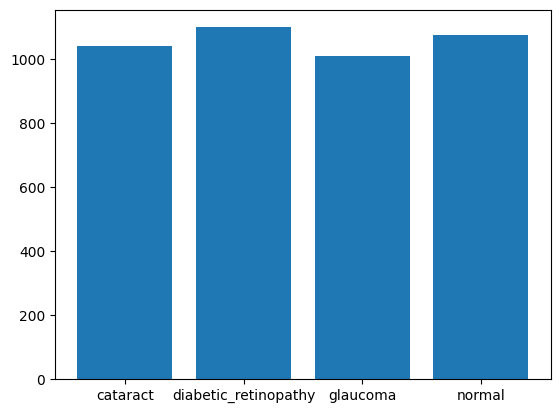

In [55]:
# 查看每种类别的比例并绘制条形图
class_names = data.class_names
labels = np.concatenate([y.numpy() for x, y in data], axis=0)
values = pd.value_counts(labels)

plt.bar(range(len(class_names)), [values[i] for i in range(len(class_names))], tick_label=class_names)
plt.show()

* 資料視覺化 (待修改)

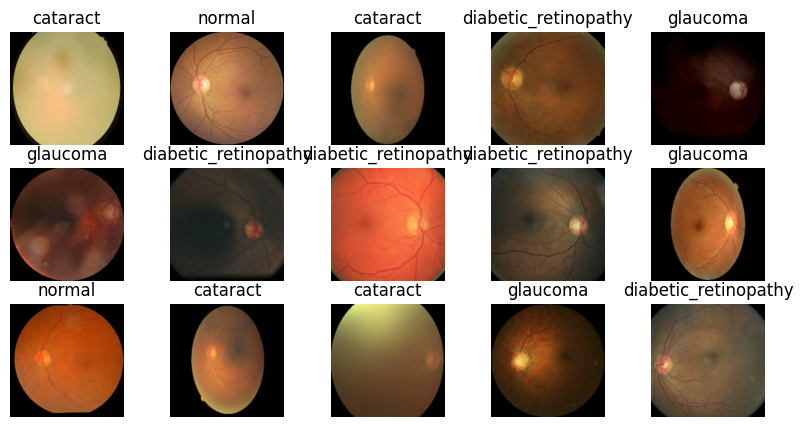

In [45]:
# 稍微看幾張圖
class_names = data.class_names
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5

for images, labels in train.take(1):
    for i in range(15):

        ax = plt.subplot(3, 5, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

        plt.axis("off")

### Data augmentation (資料增強/量)

In [46]:
df = pd.read_csv("drive/MyDrive/Colab Notebooks/eye_diseases/augmentation.csv")
augmentations = df.set_index('label').to_dict('index') #set_index()將標籤定義為新的索引值

In [47]:
df

,label,rotate 90,rotate 180,rotate 270,水平翻轉,垂直翻轉
0,normal,1,1,0,1,1
1,glaucoma,0,0,1,1,0
2,diabetic_retinopathy,0,1,1,0,0
3,cataract,1,1,1,1,1


In [48]:
augmentations

{'normal': {'rotate 90': 1,
  'rotate 180 ': 1,
  ' rotate 270': 0,
  '水平翻轉': 1,
  '垂直翻轉': 1},
 'glaucoma': {'rotate 90': 0,
  'rotate 180 ': 0,
  ' rotate 270': 1,
  '水平翻轉': 1,
  '垂直翻轉': 0},
 'diabetic_retinopathy': {'rotate 90': 0,
  'rotate 180 ': 1,
  ' rotate 270': 1,
  '水平翻轉': 0,
  '垂直翻轉': 0},
 'cataract': {'rotate 90': 1,
  'rotate 180 ': 1,
  ' rotate 270': 1,
  '水平翻轉': 1,
  '垂直翻轉': 1}}

In [66]:
def augment(image, label):
    # 使用tf.py_function来确保可以在函数内部使用Python操作
    def augment_py(image, label):
        # 获取当前标签的增强策略
        aug_ops = augmentations[label.numpy()]

        # 应用旋转增强
        if aug_ops['rotation 90度']:
            image = tf.image.rot90(image, k=1)
        elif aug_ops['rotation 180度']:
            image = tf.image.rot90(image, k=2)
        elif aug_ops['rotation 270度']:
            image = tf.image.rot90(image, k=3)

        # 应用翻转增强
        if aug_ops['水平翻轉']:
            image = tf.image.random_flip_left_right(image)
        if aug_ops['上下翻轉']:
            image = tf.image.random_flip_up_down(image)

        return image, label

    # 使用tf.py_function包装增强函数
    [image, label] = tf.py_function(augment_py, [image, label], [tf.float32, label.dtype])
    return image, label

# 实际操作数据增强:
train_dataset = train.map(lambda x, y: augment(x, y))

In [77]:
def augment(image, label):
    def augment_py(image, label):
        # 转换Tensor为numpy值
        label_value = label.numpy()[0]
        aug_ops = augmentations[label_value]

        # 应用旋转增强
        if aug_ops['rotation 90度']:
            image = tf.image.rot90(image, k=1)
        elif aug_ops['rotation 180度']:
            image = tf.image.rot90(image, k=2)
        elif aug_ops['rotation 270度']:
            image = tf.image.rot90(image, k=3)

        # 应用翻转增强
        if aug_ops['水平翻轉']:
            image = tf.image.random_flip_left_right(image)
        if aug_ops['上下翻轉']:
            image = tf.image.random_flip_up_down(image)

        return image, label

    # 使用tf.py_function来应用augment_py
    [image, label] = tf.py_function(augment_py, [image, label], [tf.float32, tf.int32])
    image.set_shape([224, 224, 3])
    return image, label

# 确保train_dataset是批处理数据集
train_dataset_augmented = train.map(augment)

In [78]:
# 可视化增强后的图像  (這段失敗)
for images, _ in train_dataset_augmented.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

UnknownError: ignored

In [ ]:
#data_augmentation = Sequential([
#        layers.experimental.preprocessing.RandomFlip("horizontal"),
#        layers.experimental.preprocessing.RandomRotation(0.2),
#    ])

In [ ]:
#datagen = ImageDataGenerator(
#  width_shift_range = 0.3,
#  height_shift_range = 0.3,
#  shear_range = 0.1,
#  rotation_range = 30)

## Model  Building and Training

### Building

* 資料前置處理

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
# prefetch()：在訓練時，同時讀取下一批資料，並作轉換。預先讀取訓練資料，以提升效能
# cache()：可將讀出的資料留在快取記憶體，之後可重複使用。
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val   = val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
train = train.map(lambda x, y: ((x/255), y))
val   = val.map(lambda x, y: ((x/255), y))

# 思考要不要用成 to_categorical ：把(label)正規化，將之轉為one-hot-encoding

* Model 架構

In [80]:
## gpt code:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 构建DenseNet模型
base_model = DenseNet121(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 编译模型
model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(train_dataset_augmented, validation_data=val, epochs=10)


Epoch 1/10


ValueError: ignored

In [ ]:
num_classes = 4 # 共4個類別
# Keras中的两种模型用法 : Sequential 和 Model
model = Sequential([
  #data_augmentation,

  Conv2D(32, (3,3), padding='same', input_shape=(224,224,3)),
  #BatchNormalization(),
  Activation('relu'),
  #BatchNormalization(),
  MaxPooling2D(),
  #Dropout(0.1),

  Conv2D(64, (3,3), padding='same'),
  #BatchNormalization(),
  Activation('relu'),
  #BatchNormalization(),
  MaxPooling2D(),
  #Dropout(0.2), # 0-1之間

  Conv2D(128, (3,3), padding='same'),
  #BatchNormalization(),
  Activation('relu'),
  #BatchNormalization(),
  MaxPooling2D(),
  #Dropout(0.2),

  Flatten(),
  Dense(256),
  #Dropout(0.5),
  #BatchNormalization(),
  Activation('relu'),
  #BatchNormalization(),
  Dense(num_classes, activation='softmax')
])

* 組裝 模型

  categorical_crossentropy : 其label是one-hot。
  sparse_categorical_crossentropy : 其label不是one-hot，而是integer


  比如在categorical_crossentropy是[1,0,0]，在sparse_categorical_crossentropy中是3.

In [ ]:
# loss + 優化 (組裝模型)
model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.01),
             metrics=['accuracy'])


In [ ]:
# 查看模型架構
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 activation_16 (Activation)  (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 activation_17 (Activation)  (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                 

* callback : 觀察訓練過程中網絡內部的狀態和統計信息

In [ ]:
# 設立 early stopping
early_stop = EarlyStopping(
        monitor="val_loss",  # 或 val_acc（val_accuracy），验证集的正确率
        patience=2,     # 可以忍受在多少个epoch内没有改进？
        verbose=1,    # 信息展示模式
        mode="min",
        restore_best_weights=True)

# mode：只有三种情况{‘min’,’max’,’auto’}，表示monitor正常情况下是上升还是下降。比如当monitor为acc时mode要设置为’max’，因为正确率越大越好，相反，当monitor为loss时mode要设置为’min’。
# restore_best_weights：当发生EarlyStopping时，模型的参数未必是最优的，即monitor的指标未必处于最优状态。如果restore_best_weights设置为True，则自动查找最优的monitor指标时的模型参数。

# ReduceLROnPlateau
Reduce = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,  # 縮放學習率的值
        patience=1,
        mode='auto',
        verbose=1,
        cooldown=0,
        min_lr=0)

callback = [early_stop, Reduce]

### Training

In [ ]:
epochs = 30
history = model.fit(train, validation_data = val, epochs = epochs, batch_size = 64, verbose = 1, callbacks=callback)
# verbose參數：代表訓練結果的顯示模式(0為不顯示、1為詳細檢視、2為簡易顯示

Epoch 1/30
47/47 [==============================] - 56s 555ms/step - loss: 1.2800 - accuracy: 0.4039 - val_loss: 1.2018 - val_accuracy: 0.4591 - lr: 0.0100
Epoch 2/30
47/47 [==============================] - 5s 111ms/step - loss: 1.1374 - accuracy: 0.4930 - val_loss: 1.0849 - val_accuracy: 0.5204 - lr: 0.0100
Epoch 3/30
47/47 [==============================] - 5s 114ms/step - loss: 1.0325 - accuracy: 0.5412 - val_loss: 0.9363 - val_accuracy: 0.6094 - lr: 0.0100
Epoch 4/30
47/47 [==============================] - 6s 117ms/step - loss: 0.9847 - accuracy: 0.5592 - val_loss: 0.9086 - val_accuracy: 0.5986 - lr: 0.0100
Epoch 5/30
47/47 [==============================] - 5s 107ms/step - loss: 0.9268 - accuracy: 0.5874 - val_loss: 0.8602 - val_accuracy: 0.6190 - lr: 0.0100
Epoch 6/30
47/47 [==============================] - 5s 112ms/step - loss: 0.8925 - accuracy: 0.6047 - val_loss: 0.8159 - val_accuracy: 0.6346 - lr: 0.0100
Epoch 7/30
47/47 [==============================] - 5s 115ms/step - l

### 可視化結果

* 可視化function建立

In [ ]:
def plot_performance(epochs, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

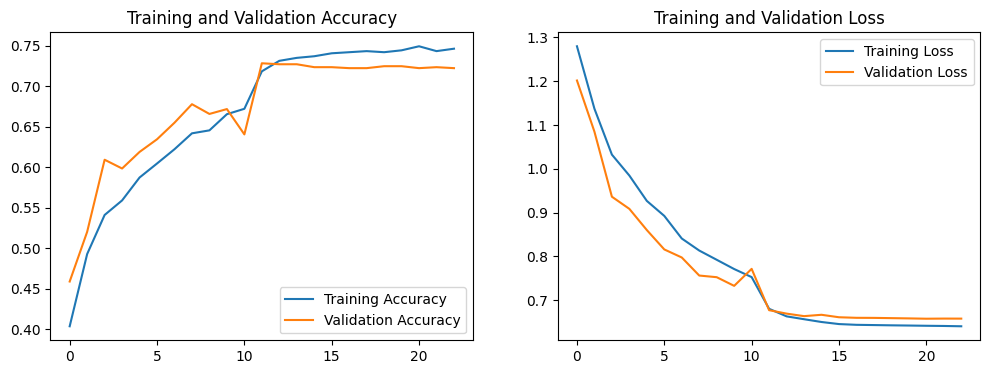

In [ ]:
epochs = history.epoch
plot_performance(epochs, history)

### Test data 評估

* Test data 評估

In [ ]:
model.evaluate(test) #評估模型，返回的是 损失值和你选定的指标值（例如，精度accuracy）

6/6 [==============================] - 22s 171ms/step - loss: 71.5557 - accuracy: 0.7135


[71.55570983886719, 0.7135278582572937]

* 製作confusion table & report

In [ ]:
# Preparing test set ：  將 test 的 images 跟 labels 弄成 dataframe
test_iter = test.as_numpy_iterator() # 返回一個迭代器，該迭代器將數據集的所有元素轉換為numpy。
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break
y_test = test_set['labels']

12/12 [==============================] - 1s 48ms/step
                      precision    recall  f1-score   support

            cataract       0.56      0.85      0.68        93
diabetic_retinopathy       0.94      0.92      0.93       104
            glaucoma       0.76      0.35      0.48        83
              normal       0.64      0.64      0.64        97

            accuracy                           0.71       377
           macro avg       0.73      0.69      0.68       377
        weighted avg       0.73      0.71      0.69       377



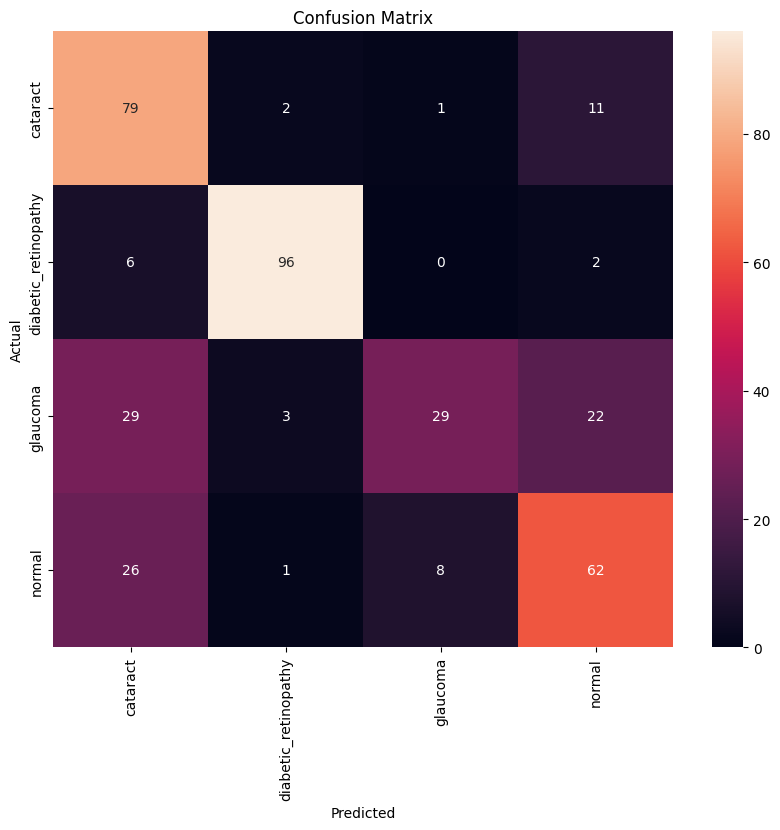

In [ ]:
def evaluate_model(model):
    y_pred = np.argmax(model.predict(test_set['images']), 1) # 返回的是沿轴axis最大值的索引值
    print(classification_report(y_test, y_pred, target_names = class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True)
    plt.xticks(np.arange(4)+.5, class_names, rotation=90)
    plt.yticks(np.arange(4)+.5, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

evaluate_model(model)